<a href="https://colab.research.google.com/github/junseok-jay/AI_lab/blob/main/week3/resample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.5 MB/s eta 0:00:00


In [29]:
import io, torch, os, tarfile, tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

import torchaudio

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

/tmp/ipython-input-3656432517.py:13: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
/tmp/ipython-input-3656432517.py:14: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
/tmp/ipython-input-3656432517.py:15: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a

In [8]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


/tmp/ipython-input-3458049858.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_WAV)


In [22]:
# Checking metadata of sample audio
mySampleUrls = [
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522039.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522040.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522041.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522042.m4a"
]

for i, path in enumerate(mySampleUrls):
  try:
    metadata = torchaudio.info(path)
    print(f"[{i}] {path}")
    print(metadata)
  except Exception as e:
    print(f"[{i}] {path} -> Error : {e}")

[0] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522039.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[1] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522040.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[2] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522041.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[3] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522042.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)


/tmp/ipython-input-307298819.py:11: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(path)


In [24]:
waveform, sample_rate = torchaudio.load(mySampleUrls[0])

In [35]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

/tmp/ipython-input-2029996078.py:3: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  new_url = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torc

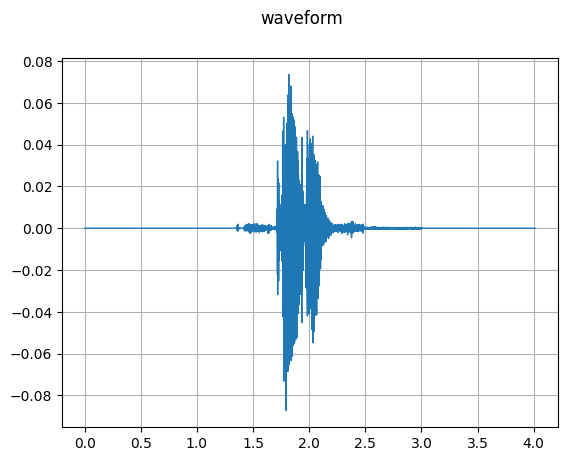

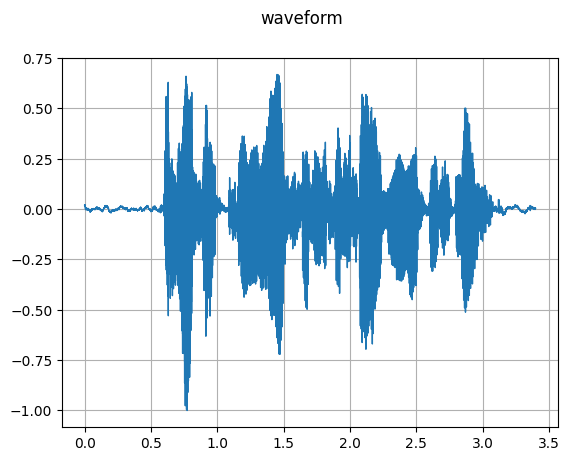

In [95]:
plot_waveform(waveform, sample_rate)

new_url = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
new_wave, new_rate = torchaudio.load(new_url)
plot_waveform(new_wave, new_rate)

In [38]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


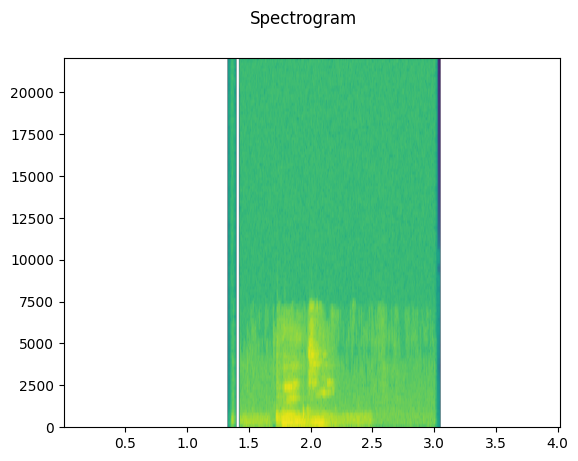

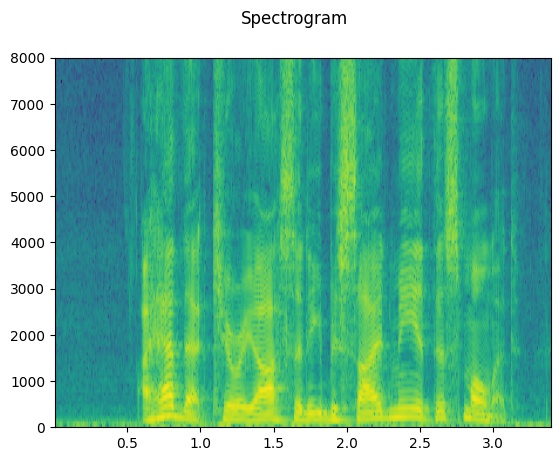

In [96]:
plot_specgram(waveform, sample_rate)
plot_specgram(new_wave, new_rate)

In [97]:
Audio(waveform.numpy()[0], rate=sample_rate)
Audio(new_wave.numpy()[0], rate=new_rate)

# Audio Resampling

In [44]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cu126


In [45]:
pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.2 MB/s eta 0:00:00


In [47]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

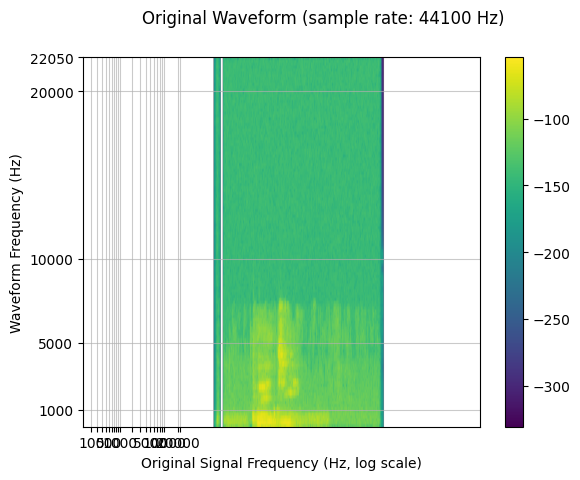

In [76]:
waveform, sample_rate = torchaudio.load(mySampleUrls[0])

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform, rate=sample_rate)

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


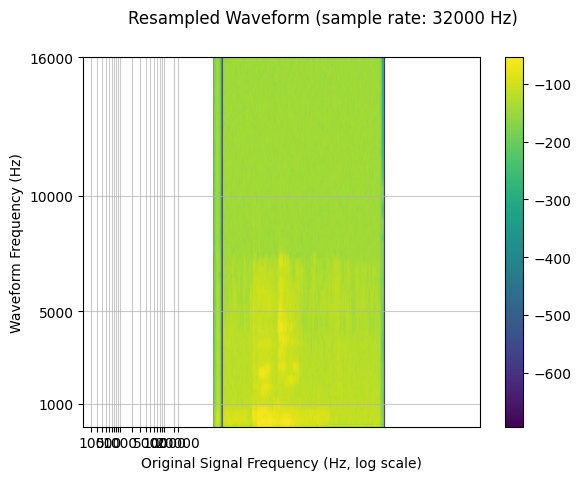

In [82]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)
# T = 1/Hz

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


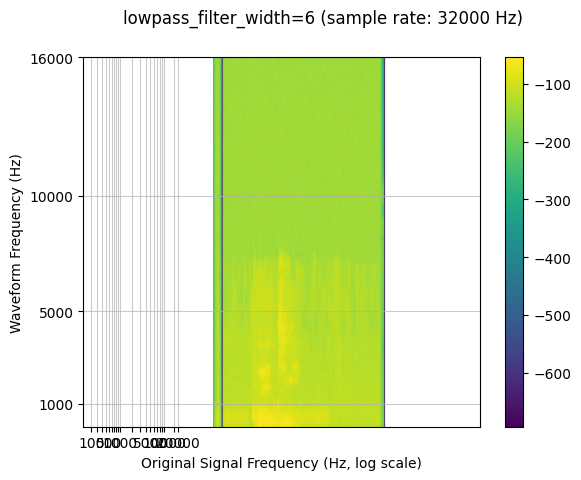

In [85]:
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


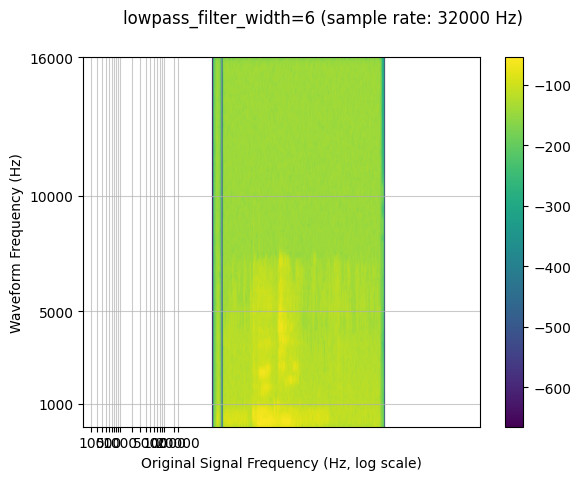

In [87]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


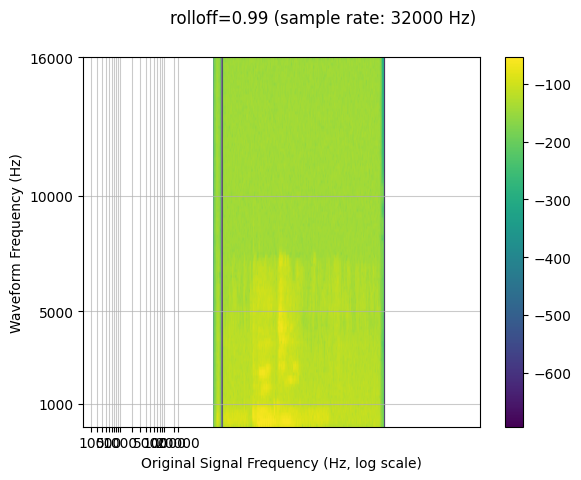

In [90]:
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


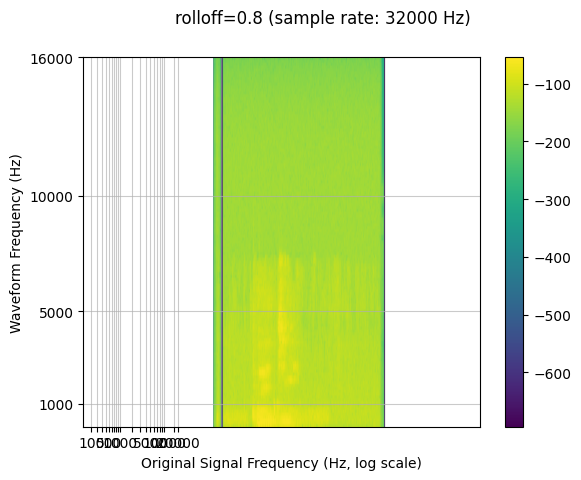

In [91]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")